=== Dummy Refinement Test ===
Output shape: torch.Size([2, 1, 64, 64])

=== Full Model Test ===
Num stacks: 2
Stack[-1] shape: torch.Size([1, 16, 64, 64])

=== Gradient Flow Check ===
wrist_refine.res1.cb.cbr1.bn.weight grad: True
wrist_refine.res1.cb.cbr1.bn.bias grad: True
wrist_refine.res1.cb.cbr1.conv.weight grad: True
wrist_refine.res1.cb.cbr1.conv.bias grad: True
wrist_refine.res1.cb.cbr2.bn.weight grad: True
wrist_refine.res1.cb.cbr2.bn.bias grad: True
wrist_refine.res1.cb.cbr2.conv.weight grad: True
wrist_refine.res1.cb.cbr2.conv.bias grad: True
wrist_refine.res1.cb.cbr3.bn.weight grad: True
wrist_refine.res1.cb.cbr3.bn.bias grad: True
wrist_refine.res1.cb.cbr3.conv.weight grad: True
wrist_refine.res1.cb.cbr3.conv.bias grad: True
wrist_refine.res1.skip.conv.weight grad: True
wrist_refine.res1.skip.conv.bias grad: True
wrist_refine.res2.cb.cbr1.bn.weight grad: True
wrist_refine.res2.cb.cbr1.bn.bias grad: True
wrist_refine.res2.cb.cbr1.conv.weight grad: True
wrist_refine.res2.cb.

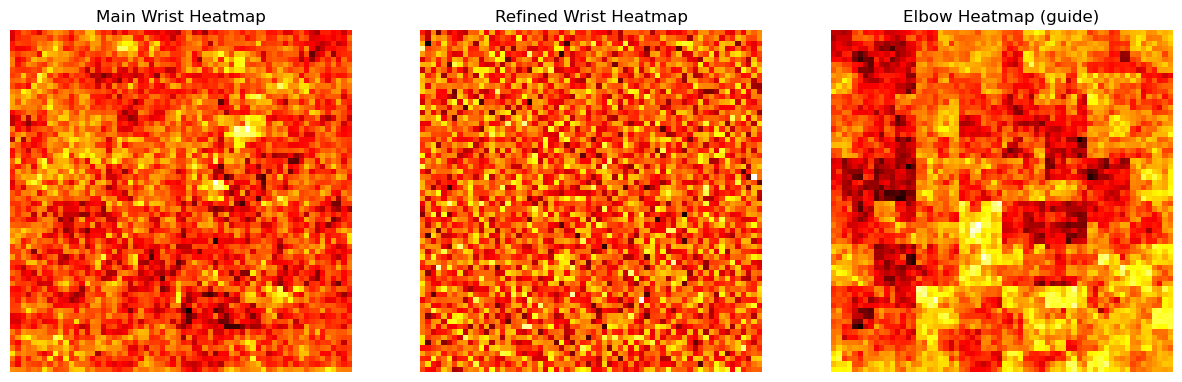

In [23]:
# Wrist Refinement Sanity Check Notebook

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- Import your model ---
from model.StackedHourGlass import get_pose_net
from model.modules.WristRefinementBranch import WristRefinementBranch

# For this notebook assume you already have:
#   - get_pose_net(in_ch=3, out_ch=16, refined=True)
#   - WristRefinementBranch defined somewhere


# 1. Dummy refinement test
print("=== Dummy Refinement Test ===")
B, C, H, W = 2, 256, 64, 64
features = torch.randn(B, C, H, W)
elbow = torch.randn(B, 1, H, W)
forearm = torch.randn(B, 1, H, W)

refine = WristRefinementBranch(in_channels=C)
out = refine(features, elbow, forearm)

print("Output shape:", out.shape)  # expect (B,1,H,W)


# 2. Plug into full model
print("\n=== Full Model Test ===")
model = get_pose_net(in_ch=3, out_ch=16, refined=True)
dummy_img = torch.randn(1, 3, 256, 256)

outputs = model(dummy_img)
print("Num stacks:", len(outputs))
print("Stack[-1] shape:", outputs[-1].shape)


# 3. Gradient flow check
print("\n=== Gradient Flow Check ===")
loss = outputs[-1].mean()
loss.backward()

for name, p in model.named_parameters():
    if "wrist_refine" in name:
        print(name, "grad:", p.grad is not None)


# 4. Visualization
print("\n=== Heatmap Visualization ===")
# take final stack
heatmaps = outputs[-1].detach()  # shape (B, J, H, W)
B, J, H, W = heatmaps.shape

right_wrist_idx = 6  # adjust to your dataset
elbow_idx = 3        # adjust as needed

# keep as tensor for refinement branch
main_wrist_tensor = heatmaps[0, right_wrist_idx: right_wrist_idx+1]  # (1,H,W)
main_elbow_tensor = heatmaps[0, elbow_idx: elbow_idx+1]               # (1,H,W)

# Re-run refinement branch explicitly
features = torch.randn(1, C, H, W)  # normally features from backbone
# add batch dimension
main_wrist_input = main_wrist_tensor.unsqueeze(0)  # (1,1,H,W)
main_elbow_input = main_elbow_tensor.unsqueeze(0)  # (1,1,H,W)
forearm_map = torch.randn_like(main_elbow_input)

refined_wrist = refine(features, main_elbow_input, forearm_map)  # (1,1,H,W)
refined_wrist_np = refined_wrist[0,0].detach().cpu().numpy()
main_wrist_np = main_wrist_tensor.detach().cpu().numpy()[0]
main_elbow_np = main_elbow_tensor.detach().cpu().numpy()[0]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(main_wrist_np, cmap="hot")
axs[0].set_title("Main Wrist Heatmap")
axs[1].imshow(refined_wrist_np, cmap="hot")
axs[1].set_title("Refined Wrist Heatmap")
axs[2].imshow(main_elbow_np, cmap="hot")
axs[2].set_title("Elbow Heatmap (guide)")

for ax in axs:
    ax.axis('off')
plt.show()

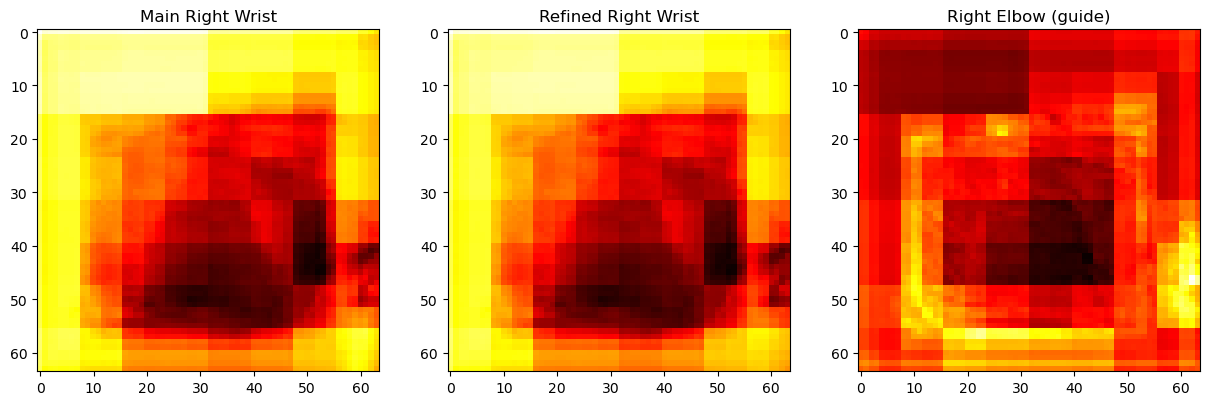

In [8]:
# Wrist Refinement Sanity Check Notebook with Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# --- Import your model ---
from model.StackedHourGlass import get_pose_net
from model.modules.WristRefinementBranch import WristRefinementBranch

# ----------------------------
# 1. Initialize model
# ----------------------------
model = get_pose_net(in_ch=3, out_ch=16, refined=True)
model.eval()  # evaluation mode

# Get refinement branch from model
refine = model.wrist_refine

# ----------------------------
# 2. Load and preprocess image
# ----------------------------
img_path = "/scratch/jmnsha002/SLP2022/SLP/danaLab/00001/RGB/cover1/image_000001.png"  # <-- Replace with your image
img = Image.open(img_path).convert("RGB")

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

img_tensor = transform(img).unsqueeze(0)  # add batch dim

# ----------------------------
# 3. Forward pass
# ----------------------------
with torch.no_grad():
    outputs = model(img_tensor)  # list of heatmaps per stack

# Take final stack heatmaps
final_heatmaps = outputs[-1].cpu()  # (1, nJoints, H, W)
B, nJ, H, W = final_heatmaps.shape

# ----------------------------
# 4. Select joints for testing
# ----------------------------
right_wrist_idx = 6   # adjust to your dataset
left_wrist_idx = 11
right_elbow_idx = 7
left_elbow_idx = 10

# Extract main heatmaps
main_right_wrist = final_heatmaps[0, right_wrist_idx]   # (H, W)
main_right_elbow = final_heatmaps[0, right_elbow_idx]   # (H, W)

# ----------------------------
# 5. Run wrist refinement
# ----------------------------
features = model.last_features  # (1, C, H, W)

refined_right_wrist = refine(
    features,
    main_right_elbow.unsqueeze(0).unsqueeze(0),  # add batch + channel dims
    main_right_wrist.unsqueeze(0).unsqueeze(0)   # add batch + channel dims
)[0,0]  # remove batch and channel dims for plotting

# Detach and move to CPU for plotting
refined_right_wrist = refined_right_wrist.detach().cpu().numpy()
main_right_wrist = main_right_wrist.detach().cpu().numpy()
main_right_elbow = main_right_elbow.detach().cpu().numpy()

# ----------------------------
# 6. Plot heatmaps
# ----------------------------
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(main_right_wrist, cmap='hot')
axs[0].set_title("Main Right Wrist")
axs[1].imshow(refined_right_wrist, cmap='hot')
axs[1].set_title("Refined Right Wrist")
axs[2].imshow(main_right_elbow, cmap='hot')
axs[2].set_title("Right Elbow (guide)")
plt.show()


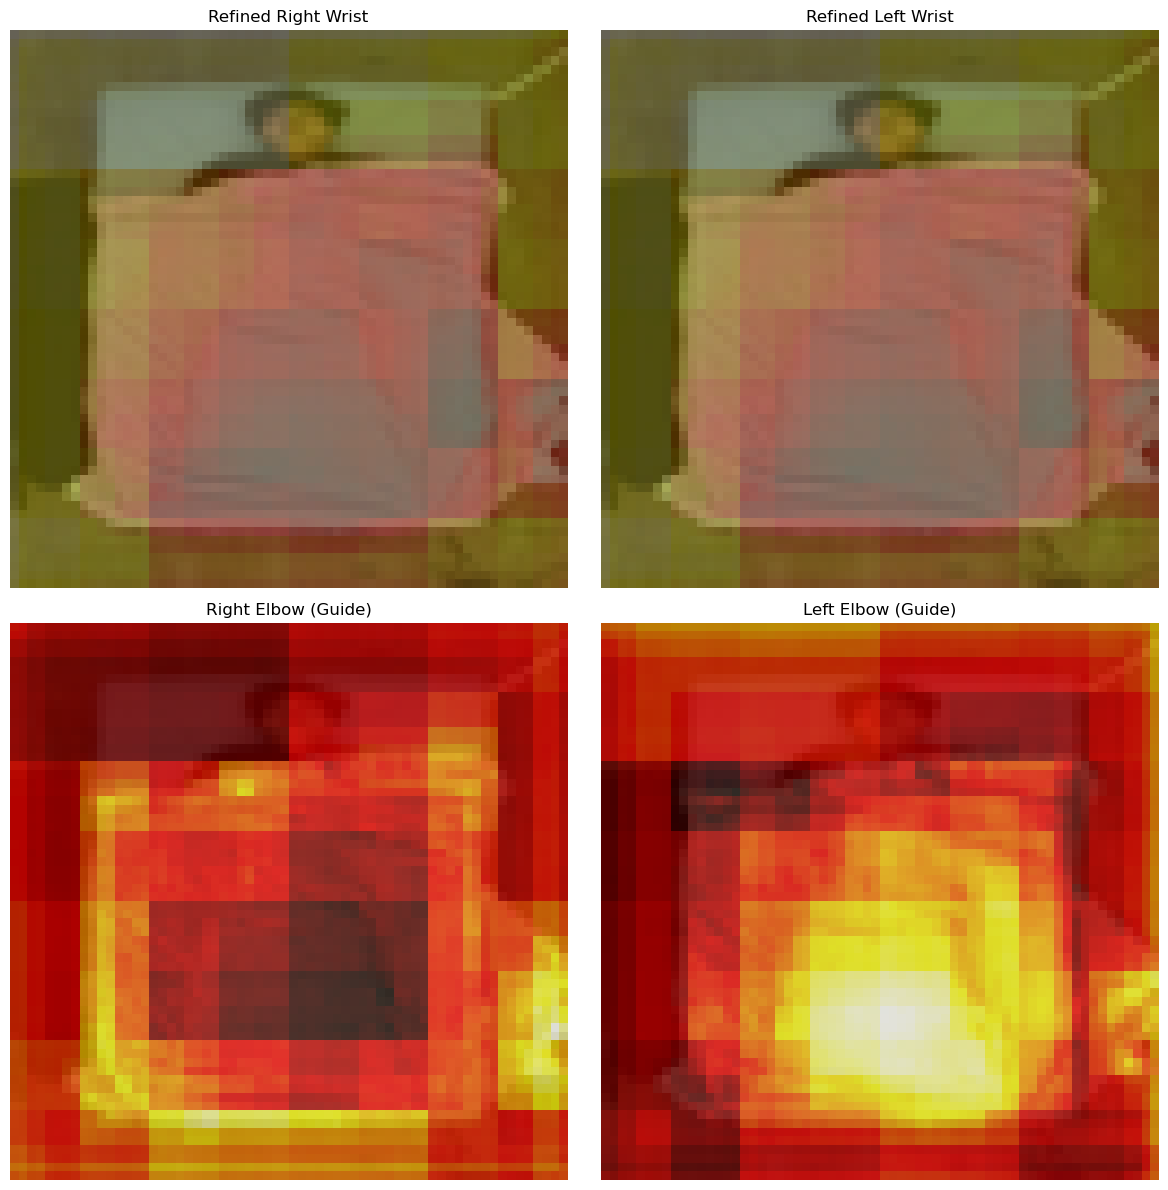

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Resize original image to match heatmap resolution
H_hm, W_hm = final_heatmaps.shape[2], final_heatmaps.shape[3]
img_resized = img.resize((W_hm, H_hm))
img_array = np.array(img_resized)  # shape (H,W,3)

# Helper to normalize heatmaps for overlay
def normalize_heatmap(hm):
    hm = hm.detach().cpu().numpy() if torch.is_tensor(hm) else hm
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)
    return hm

# Extract main heatmaps
main_right_wrist = normalize_heatmap(final_heatmaps[0, right_wrist_idx])
main_left_wrist  = normalize_heatmap(final_heatmaps[0, left_wrist_idx])
main_right_elbow = normalize_heatmap(final_heatmaps[0, right_elbow_idx])
main_left_elbow  = normalize_heatmap(final_heatmaps[0, left_elbow_idx])

# Refined wrist heatmaps
refined_right_wrist = normalize_heatmap(refine(
    model.last_features,
    final_heatmaps[0, right_elbow_idx].unsqueeze(0).unsqueeze(0),
    final_heatmaps[0, right_wrist_idx].unsqueeze(0).unsqueeze(0)
)[0,0])

refined_left_wrist = normalize_heatmap(refine(
    model.last_features,
    final_heatmaps[0, left_elbow_idx].unsqueeze(0).unsqueeze(0),
    final_heatmaps[0, left_wrist_idx].unsqueeze(0).unsqueeze(0)
)[0,0])

# ----------------------------
# Plot overlay figure
# ----------------------------
fig, axs = plt.subplots(2, 2, figsize=(12,12))

# Right wrist
axs[0,0].imshow(img_array)
axs[0,0].imshow(refined_right_wrist, cmap='hot', alpha=0.3)
axs[0,0].set_title("Refined Right Wrist")
axs[0,0].axis('off')

# Left wrist
axs[0,1].imshow(img_array)
axs[0,1].imshow(refined_left_wrist, cmap='hot', alpha=0.3)
axs[0,1].set_title("Refined Left Wrist")
axs[0,1].axis('off')

# Right elbow
axs[1,0].imshow(img_array)
axs[1,0].imshow(main_right_elbow, cmap='hot', alpha=0.7)
axs[1,0].set_title("Right Elbow (Guide)")
axs[1,0].axis('off')

# Left elbow
axs[1,1].imshow(img_array)
axs[1,1].imshow(main_left_elbow, cmap='hot', alpha=0.7)
axs[1,1].set_title("Left Elbow (Guide)")
axs[1,1].axis('off')

plt.tight_layout()
plt.show()
